<a href="https://colab.research.google.com/github/LiterallyRicky/DataScience-A2/blob/main/Rick_RiveU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Unit 5 Project: "How does shot range affect the vertical distance of shotgun shots?"**

Here we'll investigate a dataset revolving around predicting vertical distance with the shot range in shotgun shots.


---



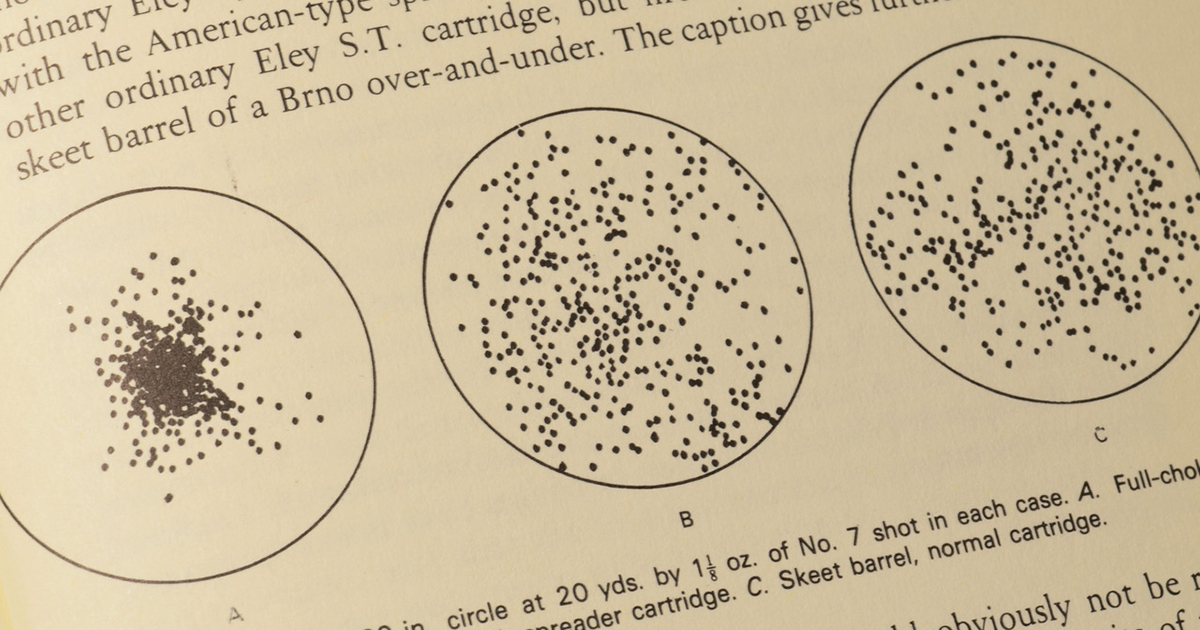

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

#**Context and Showcasing Data**

Okay, so this project is going to be different. Usually, I'd like to pick a dataset that revolves around technology but while looking through a dataset website that Mr. Arredondo posted ([Linked Here](https://users.stat.ufl.edu/~winner/datasets.html)), I thought this dataset that I stumbled across was pretty interesting.

In this dataset, there's 5 columns: pellDiam, shotRng,shotID, vertDist, and horzDist all corresponding to shotgun shots/pellets.

**Note:** Here's the description of the dataset:
- Description: Results of experiment measuring maximal vertical and horizontal spreads (mm) of pellets shot from a Hugsan (12/76 Magnum, 52 cm cylinder bored barrel) and cartridges (70mm) by MKE.
- Pellet Diameters (mm): 2, 3.5, 5, 8
- Shot Ranges *(Distance away from a target)* (m): 0.7, 0.8, 0.9, 1, 2, 3, 5, 10, 15, 20, 25
- Regression models fit relating Vertical and Horizontal distances to Shot Range by pellet size
- 5 Replicates per pellet size and shot range

I think it'll be pretty interesting to see the linear model in this dataset and seeing how the shooting range affects the vertical distance of a shot. I'll plot the dataset below!


In [ ]:
url_shotgun = 'https://raw.githubusercontent.com/LiterallyRicky/DataScience-A2/main/shotgun_spread2.csv'
shotgun_spread = pd.read_csv(url_shotgun)

In [ ]:
shotgun_spread

,pellDiam,shotRng,shotID,vertDist,horzDist
0,2.0,0.7,1,20,16
1,2.0,0.7,2,20,20
2,2.0,0.7,3,21,20
3,2.0,0.7,4,20,19
4,2.0,0.7,5,20,20
...,...,...,...,...,...
215,8.0,25.0,1,400,460
216,8.0,25.0,2,425,400
217,8.0,25.0,3,450,342
218,8.0,25.0,4,490,500


Now, let's make a scatterplot: shot range vs horizontal distance.

<Axes: xlabel='shotRng', ylabel='vertDist'>

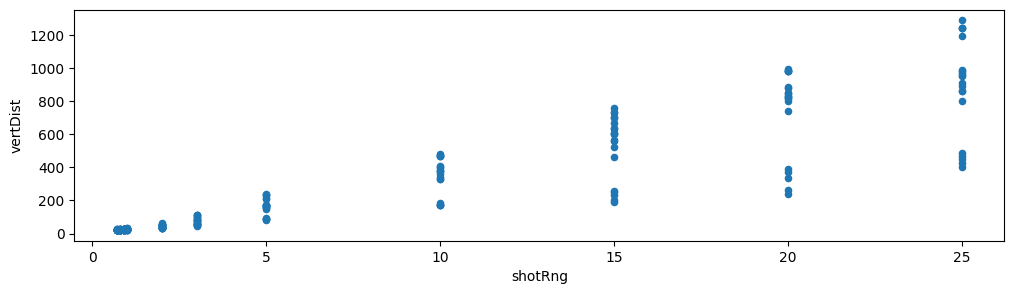

In [ ]:
#scatter plot of shot range vs horizontal distance
shotgun_spread.plot(x="shotRng", y="vertDist", figsize=(12, 3), kind="scatter")

Okay so we can definitely see that there's a correlation between "Shot Range" and "Vertical Distance". This is great, we can actually continue the project now.

Let's start with creating the models to determine the posteriors, mean lines, and PPCs.

#**Creating the models:**

**Model 1: No Changes**


---


Okay so I'm going to be using the code provided for us in the Notes/AK and change the variable names to fit my dataset. We'll use this as a basis for our model improvement later on.

In [ ]:
#ss = shotgun spread
with pm.Model() as model_ss1:

    # Priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    # The linear model
    μ = pm.Deterministic("μ", α + β * shotgun_spread.shotRng)

    # Prior for the standard deviation of the likelihood
    σ = pm.HalfCauchy("σ", 10)

    # Likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=shotgun_spread.vertDist)

    # Inference data object
    idata_ss1 = pm.sample()

Output()

Output()

Perfect, no divergences which is pretty good. However, I am just using example code from the notes so the PPC shouldn't match up correctly. This is fine, we'll improve that later.

Below will show the priors used for this model.

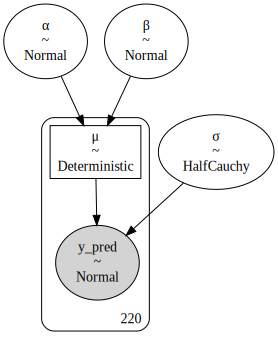

In [ ]:
pm.model_to_graphviz(model_ss1)

Now, let's look at each posterior below.

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

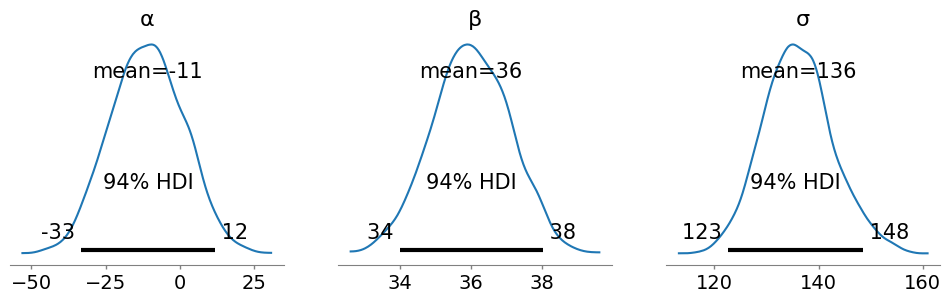

In [ ]:
az.plot_posterior(idata_ss1, var_names=["~μ"], figsize=(12, 3))

Okay interesting. Our alpha posterior is in the negatives. Uhm, this shouldn't be doing that since our values aren't negative. We definitely need to change that in the next model we make.

Text(0, 0.5, 'Vertical Distance')

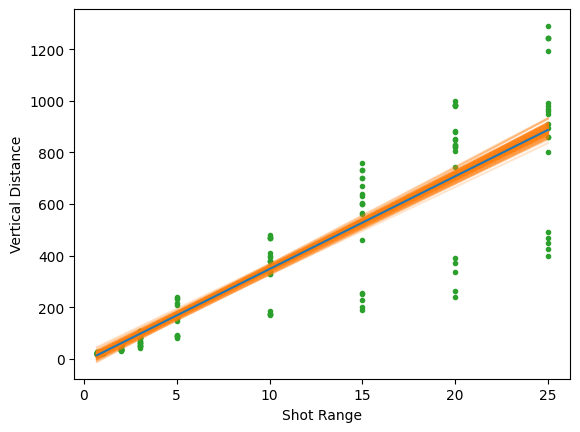

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_ss1, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(shotgun_spread.shotRng.min(), shotgun_spread.shotRng.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

Our expected line shows the general trend for our raw data. With the line, we can tell that the line has a positive correlation meaning that when our vertical distance increases, shot range increases as well. Nice!

Let's continue on with the PPC. Now we'll see if it fits reality.

In [ ]:
# posterior predictive check
pm.sample_posterior_predictive(idata_ss1, model=model_ss1,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Vertical Distance')

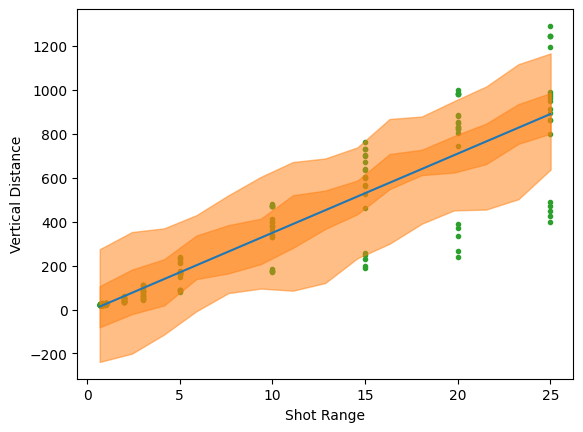

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_ss1.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
shotguns = np.random.normal(shotgun_spread.shotRng.values, 0.01)
idx = np.argsort(shotguns)
x = np.linspace(shotguns.min(),shotguns.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_ss1.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(shotguns[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C2.", zorder=-3)
ax.plot(shotgun_spread.shotRng[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

Okay, pretty good. The posterior predictive distribution seems to fit the general trend of the scatter plot and MOST of the points, although misses some of the critical ones unfortunately.

<Axes: xlabel='y_pred'>

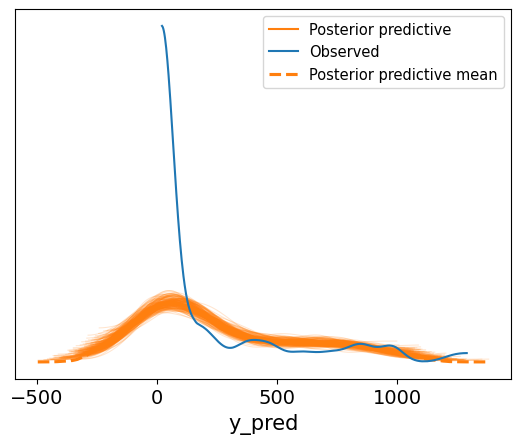

In [ ]:
#posterior predictive check
az.plot_ppc(idata_ss1, num_pp_samples=200, colors=["C1", "C0", "C1"])

The PPC model is pretty bad and doesn't fit at all. Possibly changing the likelihood and some of the other variables when creating the model would be neccessary for the PPC model to fit better. My first thoughts in changing the model would be using a likelihood, something like a halfnormal and/or negative binomial distribution, to show a decline like the observed line shows.

#**Improving the model (GLM):**

**Model 2: Changed Likelihood - Negative Binomial Distribution + Changed HalfCauchy to HalfNormal**


---



In [ ]:
with pm.Model() as model_nbss:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", (α + β * shotgun_spread.shotRng))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 5)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=shotgun_spread.vertDist)

    idata_nbss = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

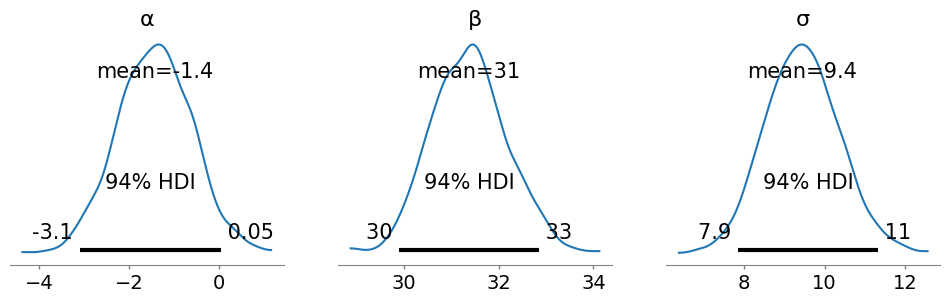

In [ ]:
az.plot_posterior(idata_nbss, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'Vertical Distance')

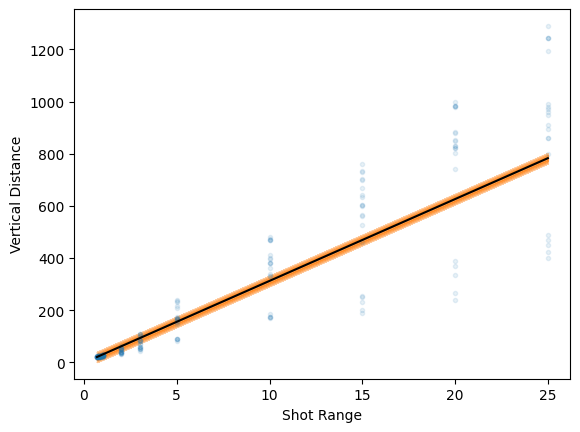

In [ ]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C0.", alpha=0.1)

posterior_nbss = az.extract(idata_nbss)

μ_m = posterior_nbss["μ"].mean("sample").values
σ_m = posterior_nbss["σ"].mean("sample").values

ax.plot(shotgun_spread.shotRng, μ_m, c="k")
ax.fill_between(shotgun_spread.shotRng, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(shotgun_spread.shotRng, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

Again, the line that was made to create the correlation for our data is pretty good and models the data well.

In [ ]:
pm.sample_posterior_predictive(
    idata_nbss, model = model_nbss, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Vertical Distance')

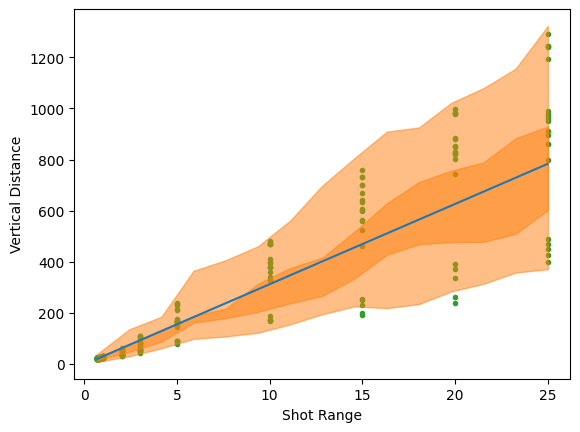

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_nbss.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
shotguns = np.random.normal(shotgun_spread.shotRng.values, 0.01)
idx = np.argsort(shotguns)
x = np.linspace(shotguns.min(),shotguns.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_nbss.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(shotguns[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C2.", zorder=-3)
ax.plot(shotgun_spread.shotRng[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

This is really good! The model captures so many points on the graph that wasn't being captured previously in model 1.

(0.0, 1400.0)

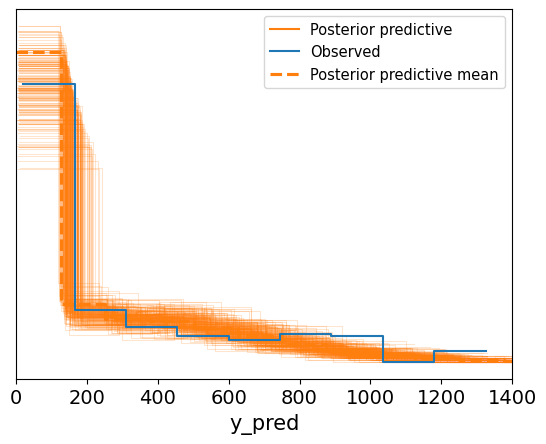

In [ ]:
# posterior predictive check
y = az.plot_ppc(idata_nbss, num_pp_samples=200, colors=["C1", "C0", "C1"])
y.set_xlim(0, 1400)

Since my graph somewhat looks like the negative binomial distribution, I knew that if I were to use that distribution as my likelihood, this PPC would be better. The PPC has a pretty good match in the similarities in shape where the observed line matches that decrease in the beginning of the PPC.

**Model 3: Changed Likelihood - Chi-Squared + Changing HalfNormal back to HalfCauchy**


---



In [ ]:
with pm.Model() as model_css:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", (α + β * shotgun_spread.shotRng))

    #prior for the likelihood's standard deviation
    σ = pm.HalfCauchy("σ", 5)

    #likelihood
    y_pred = pm.ChiSquared("y_pred", nu=μ, observed=shotgun_spread.vertDist)

    idata_css = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

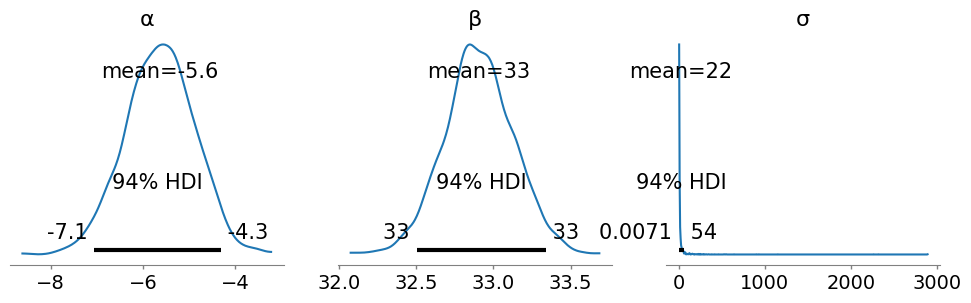

In [ ]:
az.plot_posterior(idata_css, var_names=["~μ"], figsize=(12, 3))

Interesting, I haven't seen the sigma posterior to have this type of graph/curve before but I'm guessing it's the influence from the Chi-Squared distribution likelihood.

Text(0, 0.5, 'Vertical Distance')

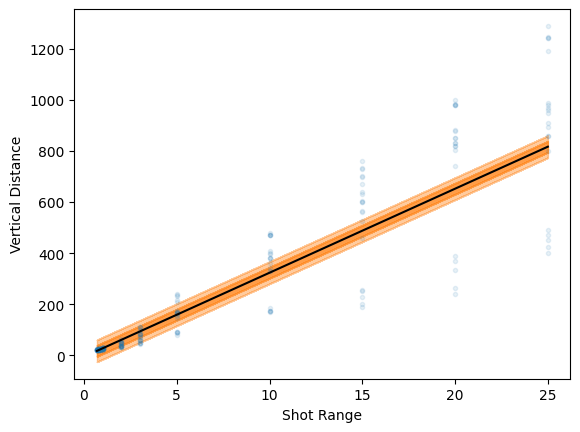

In [ ]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C0.", alpha=0.1)

posterior_nbls = az.extract(idata_css)

μ_m = posterior_nbls["μ"].mean("sample").values
σ_m = posterior_nbls["σ"].mean("sample").values

ax.plot(shotgun_spread.shotRng, μ_m, c="k")
ax.fill_between(shotgun_spread.shotRng, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(shotgun_spread.shotRng, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

Great, the line matches with the correlation of the model well, but I feel like it doesn't capture most of the "extreme" points.

Now, let's see how the posterior predictive distribution looks like.

In [ ]:
pm.sample_posterior_predictive(
      idata_css, model = model_css, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Vertical Distance')

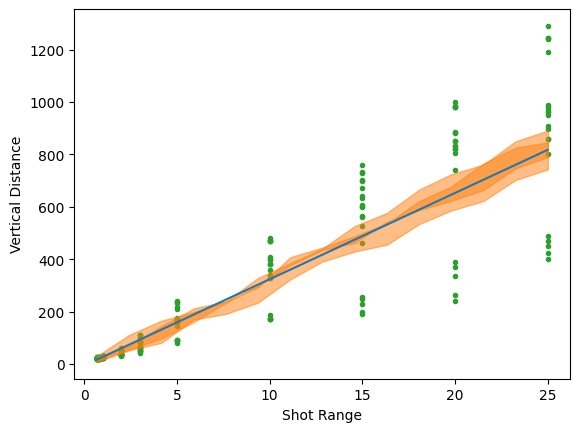

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_css.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
shotguns = np.random.normal(shotgun_spread.shotRng.values, 0.01)
idx = np.argsort(shotguns)
x = np.linspace(shotguns.min(),shotguns.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_css.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(shotguns[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C2.", zorder=-3)
ax.plot(shotgun_spread.shotRng[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

Okay so this graph is not capturing most of the data points that are in our dataset. Not great, could definitely be better.

<Axes: xlabel='y_pred'>

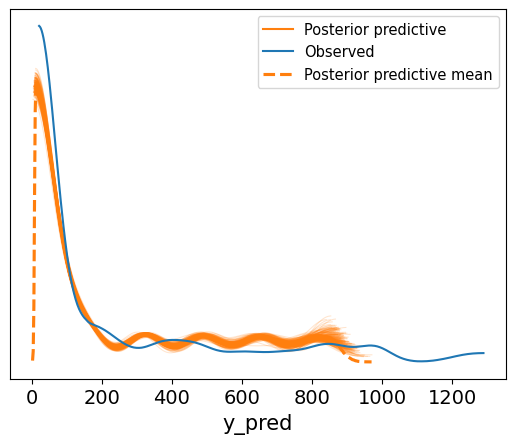

In [ ]:
# posterior predictive check
az.plot_ppc(idata_css, num_pp_samples=200, colors=["C1", "C0", "C1"])

This PPC model is actually not bad. I thought that with having a couple of divergences, the model wouldn't match well but it isn't the worst. The general shape is there, the left side of the distribution matches good, but towards the right side, the PPC line gets a bit wonky. However, it's a good representation on reality though!

**Model 4: Added exponential on linear part of the model**


---



In [ ]:
with pm.Model() as model_css2:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * shotgun_spread.shotRng))

    #prior for the likelihood's standard deviation
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.ChiSquared("y_pred", nu=μ, observed=shotgun_spread.vertDist)

    idata_css2 = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

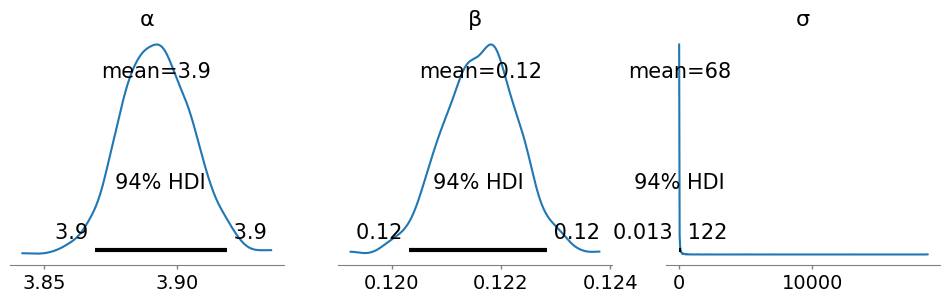

In [ ]:
az.plot_posterior(idata_css2, var_names=["~μ"], figsize=(12, 3))

Interesting, so having incorporation of a chi-squared plus a halfcauchy distribution, the standard deviation posterior graph just turns out to be a distribution that is complied on the left side and having a really long tail on the right. However, I can tell that this is in par with a plotting issue. If we'd zoom into the chi-squared model only, we'd see what's actually happening.

Text(0, 0.5, 'Vertical Distance')

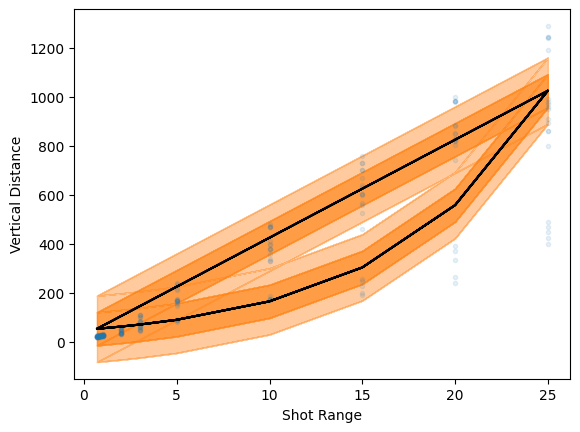

In [ ]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C0.", alpha=0.1)

posterior_nbls = az.extract(idata_css2)

μ_m = posterior_nbls["μ"].mean("sample").values
σ_m = posterior_nbls["σ"].mean("sample").values

ax.plot(shotgun_spread.shotRng, μ_m, c="k")
ax.fill_between(shotgun_spread.shotRng, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(shotgun_spread.shotRng, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

Interesting, so the trend of increase is shown but I wonder how this will affect the PPC below.

In [ ]:
pm.sample_posterior_predictive(
      idata_css2, model = model_css2, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Vertical Distance')

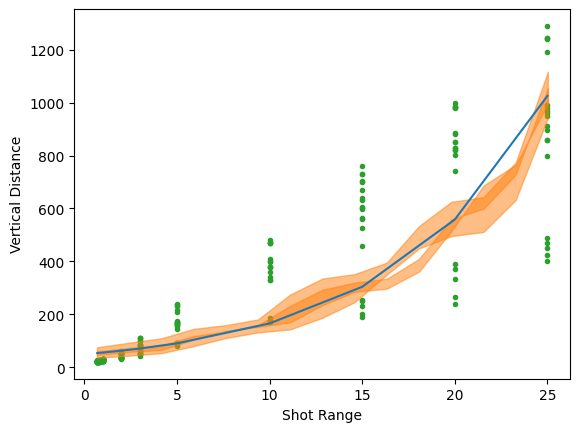

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_css2.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
shotguns = np.random.normal(shotgun_spread.shotRng.values, 0.01)
idx = np.argsort(shotguns)
x = np.linspace(shotguns.min(),shotguns.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_css2.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(shotguns[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C2.", zorder=-3)
ax.plot(shotgun_spread.shotRng[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

With this posterior predictive distribution graph, the line shows somewhat the trend of increase but capturing most of the further data points is non-existent. This is a gigantic disadvantage in the model and it'll most likely show in the PPC:

<Axes: xlabel='y_pred'>

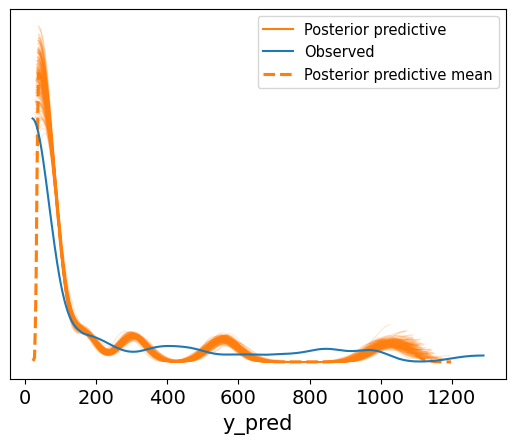

In [ ]:
# posterior predictive check
az.plot_ppc(idata_css2, num_pp_samples=200, colors=["C1", "C0", "C1"])

This graph is alright, however, the ending of the graph isn't really matched up well.

I think that the likelihood I used for the second model, the negative binomial, was being matched pretty well when showing the posterior predictive check and it's distribution on a line graph. For the next model, I should try to use that again but change some of the parameters like the likelihood's standard deviation.

**Model 5: Changed Likelihood - Negative Binomial + Changing HalfCauchy back to HalfNormal**


---

In [ ]:
with pm.Model() as model_nbss2:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=100, sigma=10)
    β = pm.Normal("β", mu=100, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", α + β * (shotgun_spread.shotRng))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 100)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=shotgun_spread.vertDist)

    idata_nbss2 = pm.sample()

Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

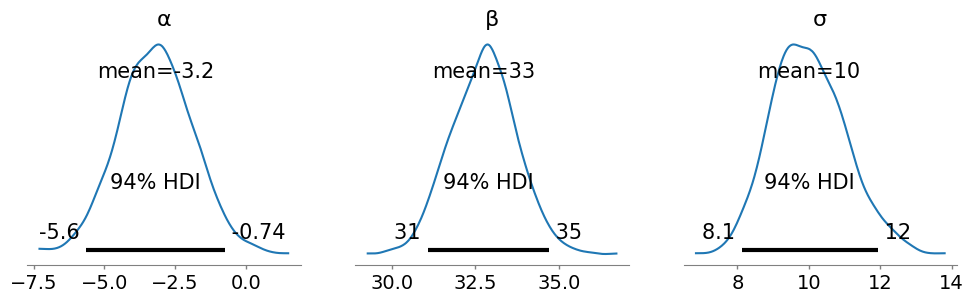

In [ ]:
az.plot_posterior(idata_nbss2, var_names=["~μ"], figsize=(12, 3))

Like I described above, I did just that. I changed the likelihood back to Negative Binomial hoping for good results like the second model brought. I also changed the mu to 100 on the priors for the linear part of the model. Why? I wanted to play with the model a bit and see what type of changes the sigma and mu brings. Let's see what happens.

Text(0, 0.5, 'Vertical Distance')

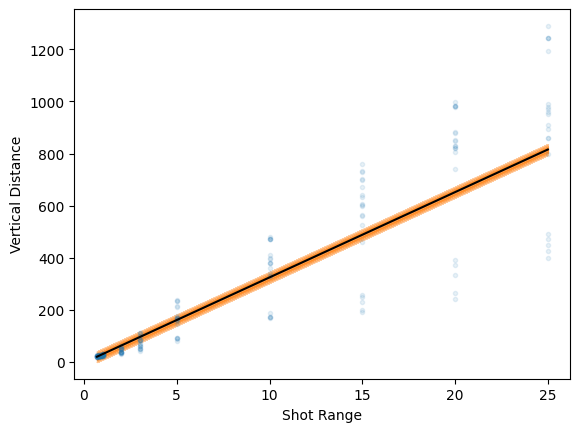

In [ ]:
#plots the posterior

_, ax = plt.subplots()

ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C0.", alpha=0.1)

posterior_nbss2 = az.extract(idata_nbss2)

μ_m = posterior_nbss2["μ"].mean("sample").values
σ_m = posterior_nbss2["σ"].mean("sample").values

ax.plot(shotgun_spread.shotRng, μ_m, c="k")
ax.fill_between(shotgun_spread.shotRng, μ_m + 1 * σ_m, μ_m - 1 * σ_m, alpha=0.6, color="C1")
ax.fill_between(shotgun_spread.shotRng, μ_m + 2 * σ_m, μ_m - 2 * σ_m, alpha=0.4, color="C1")

ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

Greatly matched with the trend of the data, showing that increase between the relationship of vertical distance and shot range.

In [ ]:
pm.sample_posterior_predictive(
      idata_nbss2, model = model_nbss2, extend_inferencedata=True
    )

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Vertical Distance')

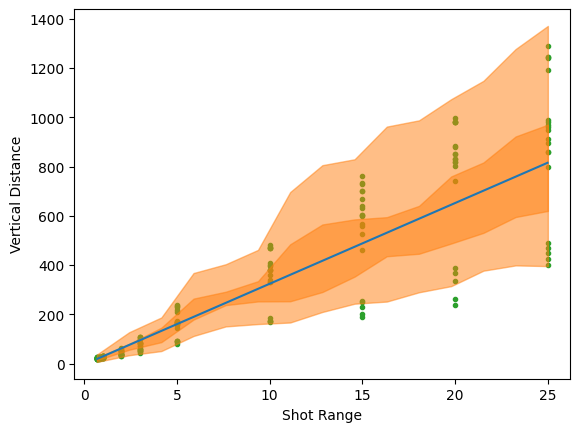

In [ ]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_nbss2.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
shotguns = np.random.normal(shotgun_spread.shotRng.values, 0.01)
idx = np.argsort(shotguns)
x = np.linspace(shotguns.min(),shotguns.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_nbss2.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(shotguns[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(shotgun_spread.shotRng, shotgun_spread.vertDist, "C2.", zorder=-3)
ax.plot(shotgun_spread.shotRng[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Shot Range")
ax.set_ylabel("Vertical Distance")

Again, this is one, if not the best, posterior predictive distribution I've made. This is primarily due to the capturing of almost ALL of the points that are somewhat "extreme" (not really sure how to describe it, but points that are 'further away' from majority of the points), which means that it's representative of almost all of the data!

(0.0, 1400.0)

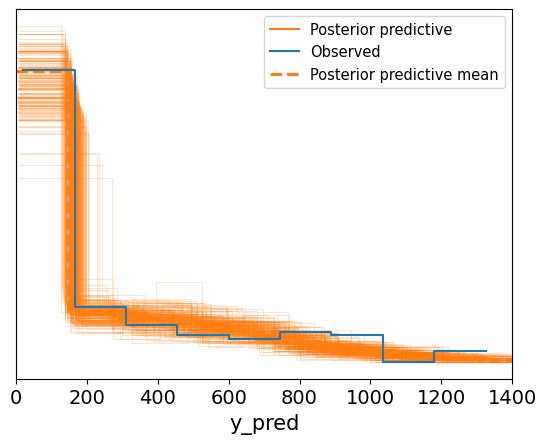

In [ ]:
# posterior predictive check
x = az.plot_ppc(idata_nbss2, num_pp_samples=200, colors=["C1", "C0", "C1"])
x.set_xlim(0, 1400)

Great, I love how this distribution matches up with the sharp decline near the 200 'spot' and how it matches up with the beginning of the tail. For some reason, Model 5's PPC was incredibly good at captured the posterior predictive mean line toward the peak on the left. There's some inaccuracies in some parts at the end of the tail, but this PPC is really good!

#**Final Thoughts:**

To gain from this is that generally, when shot range, shots taken at different ranges from a target, increases, vertical distance increases as well. With having both Model 2 and Model 5's PPC have a great similarity between each other and both being the best models I've created, I'm not sure how to decide between one another. However, I can say that using a negative binomial distribution was a great likelihood to use. Here are the models:



---



(0.0, 1400.0)

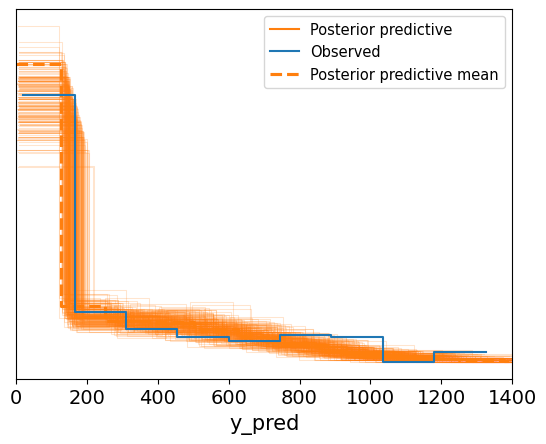

In [ ]:
# posterior predictive check
y = az.plot_ppc(idata_nbss, num_pp_samples=200, colors=["C1", "C0", "C1"])
y.set_xlim(0, 1400)

(0.0, 1400.0)

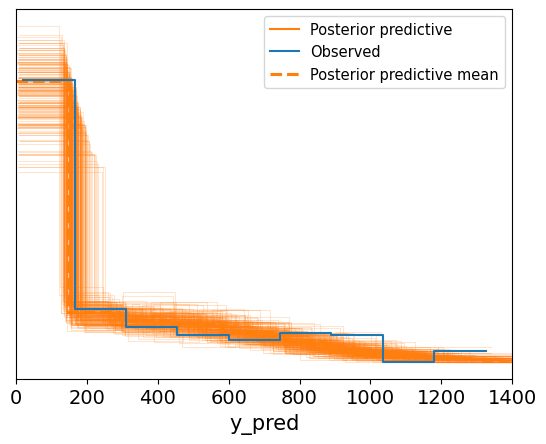

In [ ]:
# posterior predictive check
x = az.plot_ppc(idata_nbss2, num_pp_samples=200, colors=["C1", "C0", "C1"])
x.set_xlim(0, 1400)



---



As well, I really love how both models capture almost every single point, showcasing that when plotting the posterior predictive distributions.